In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [59]:
# ========== ⚙️ Global Config ==========
EXCEL_INPUT = "3.1 etf_with_ark_analysis_clean.xlsx"
EXCEL_SHEET = "Comparable ETFs"
ROLLING_WINDOWS = [12, 36, 60]
CORR_TARGET_ETF = "ARKK"
MIN_START_DATE = "2000-01-01"


# ========== 🧾 Load ETF Tickers ==========
def load_etf_list(file=EXCEL_INPUT, sheet=EXCEL_SHEET):
    df = pd.read_excel(file, sheet_name=sheet, engine="openpyxl")
    tickers = df.iloc[:, 0].dropna().astype(str).tolist()
    print(f"✅ Loaded {len(tickers)} ETF tickers.")
    return tickers

# ========== 📈 Fetch Daily Close Prices ==========
def fetch_daily_close(tickers, start=MIN_START_DATE):
    price_data = {}
    failed = []
    for ticker in tickers:
        try:
            print(f"⬇️ Fetching: {ticker}")
            close = yf.download(ticker, start=start, interval="1d", progress=False)["Close"].dropna()
            price_data[ticker] = close
        except Exception as e:
            print(f"❌ {ticker} failed: {e}")
            failed.append(ticker)

    df_close = pd.concat(price_data, axis=1)
    df_close.columns = df_close.columns.get_level_values(0)
    df_close.index.name = "Date"

    print("✅ Completed fetching all ETF prices.")
    return df_close, failed



# ========== 🚦 Main Input Setup ==========
tickers = load_etf_list()
df_close, failed = fetch_daily_close(tickers)


if CORR_TARGET_ETF in df_close.columns:
    ark_start = df_close[CORR_TARGET_ETF].dropna().index.min()
    df_close = df_close[df_close.index >= ark_start]
    print(f"📌 Data aligned to ARKK start date: {ark_start.date()}")
else:
    raise ValueError("ARKK not found in price data.")


✅ Loaded 131 ETF tickers.
⬇️ Fetching: ARKK
⬇️ Fetching: ARKG
⬇️ Fetching: ARKW
⬇️ Fetching: ARKF
⬇️ Fetching: ARKQ
⬇️ Fetching: ARKX
⬇️ Fetching: ARKB
⬇️ Fetching: IZRL
⬇️ Fetching: PRNT
⬇️ Fetching: ILDR
⬇️ Fetching: BUYZ
⬇️ Fetching: FDIF
⬇️ Fetching: EVMT
⬇️ Fetching: ARKZ
⬇️ Fetching: DYNI
⬇️ Fetching: ARKW
⬇️ Fetching: SYNB
⬇️ Fetching: TSLT
⬇️ Fetching: WGMI
⬇️ Fetching: AIYY
⬇️ Fetching: SARK
⬇️ Fetching: TIME
⬇️ Fetching: MAGS
⬇️ Fetching: CEPI
⬇️ Fetching: FDG
⬇️ Fetching: BMED
⬇️ Fetching: MEDX
⬇️ Fetching: DRAI
⬇️ Fetching: TEK
⬇️ Fetching: NVDL
⬇️ Fetching: PJFG
⬇️ Fetching: WAR
⬇️ Fetching: CHAT
⬇️ Fetching: JDOC
⬇️ Fetching: ARKY
⬇️ Fetching: TESL
⬇️ Fetching: MOTO
⬇️ Fetching: FWD
⬇️ Fetching: YMAG
⬇️ Fetching: BKCH
⬇️ Fetching: AOTG
⬇️ Fetching: XPND
⬇️ Fetching: JTEK
⬇️ Fetching: HRTS
⬇️ Fetching: BETE
⬇️ Fetching: BETH
⬇️ Fetching: FMED
⬇️ Fetching: FFND
⬇️ Fetching: FDCF
⬇️ Fetching: AMOM
⬇️ Fetching: NBDS
⬇️ Fetching: MEDI
⬇️ Fetching: LCLG
⬇️ Fetching: TEKX
⬇️ Fet

In [60]:
def get_risk_free_rate():
    irx = yf.Ticker("^IRX")
    rate = irx.history(period="5d")["Close"].dropna()
    rate = rate[rate > 0]
    if not rate.empty:
        return rate.iloc[-1] / 100 / 12  # convert to monthly
    else:
        raise ValueError("Unable to fetch valid risk-free rate.")


def compute_max_drawdown(series):
    if series.empty:
        return np.nan
    cummax = series.cummax()
    drawdown = (series - cummax) / cummax
    return drawdown.min()

def compute_return_to_mdd(returns):
    cumulative = (1 + returns).cumprod()
    if len(cumulative) < 2:
        return np.nan
    total_ret = cumulative.iloc[-1] / cumulative.iloc[0] - 1
    mdd = compute_max_drawdown(cumulative)
    return total_ret / abs(mdd) if mdd != 0 else np.nan

def build_df(series_dict):
    df = pd.concat(series_dict, axis=1)
    df.columns = df.columns.get_level_values(0)
    df.index.name = "Date"
    return df

def compute_sharpe(returns, risk_free_rate):
    excess = returns - risk_free_rate
    if excess.std() > 0:
        return (excess.mean() / excess.std()) * np.sqrt(12)  # 年化 Sharpe
    else:
        return np.nan

def compute_fixed_window_rolling_corr(df, target_col, etf_list, window, label=""):
    result = {}
    for etf in etf_list:
        if etf == target_col or etf not in df.columns:
            continue
        aligned = df[[target_col, etf]].dropna()
        if len(aligned) < window:
            continue
        def corr_fn(x):
            x = x.reshape(-1, 2)
            if np.std(x[:, 0]) == 0 or np.std(x[:, 1]) == 0:
                return np.nan
            return np.corrcoef(x[:, 0], x[:, 1])[0, 1]
        rolling_corr = aligned.rolling(window).apply(corr_fn, raw=True)
        result[etf] = rolling_corr[target_col]
    df_result = pd.DataFrame(result)
    df_result.index.name = "Date"
    return df_result

def analyze_sharpe_vs_romad_all_etfs_all_months(df_sharpe, df_romad):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Step 1
    common_etfs = df_sharpe.columns.intersection(df_romad.columns)
    df_sharpe = df_sharpe[common_etfs]
    df_romad = df_romad[common_etfs]

    # Step 2: DataFrame（Date, ETF, Sharpe, RoMaD, Group）
    long_sharpe = df_sharpe.stack().rename("Sharpe")
    long_romad = df_romad.stack().rename("RoMaD")

    df_all = pd.concat([long_sharpe, long_romad], axis=1).dropna().reset_index()
    df_all.columns = ["Date", "ETF", "Sharpe", "RoMaD"]
    df_all["Group"] = df_all["ETF"].apply(lambda x: "ARK" if x.startswith("ARK") else "Other")

    # Step 3: reference line（RoMaD = Sharpe²）
    sharpe_range = np.linspace(df_all["Sharpe"].min(), df_all["Sharpe"].max(), 300)
    theoretical_romad = sharpe_range ** 2

    # Step 4
    plt.figure(figsize=(10, 6))
    plt.scatter(df_all[df_all["Group"] == "Other"]["Sharpe"],
                df_all[df_all["Group"] == "Other"]["RoMaD"],
                color="lightgray", alpha=0.5, s=20, label="Other ETFs")

    plt.scatter(df_all[df_all["Group"] == "ARK"]["Sharpe"],
                df_all[df_all["Group"] == "ARK"]["RoMaD"],
                color="crimson", alpha=0.8, s=25, edgecolors="black", label="ARK ETFs")

    plt.plot(sharpe_range, theoretical_romad, linestyle="--", color="black", label="Theory: RoMaD ∝ Sharpe²")

    plt.axhline(0, linestyle="--", linewidth=0.5, color="gray")
    plt.axvline(0, linestyle="--", linewidth=0.5, color="gray")
    plt.title("Sharpe vs. RoMaD: Every ETF, Every Month")
    plt.xlabel("Rolling 12M Sharpe Ratio")
    plt.ylabel("Rolling 36M RoMaD")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("4.7 sharpe_vs_romad_every_point.png", dpi=300)
    plt.show()

    # Step 5: output
    total_etfs = df_all["ETF"].nunique()
    total_points = len(df_all)

    ark_etfs = df_all[df_all["Group"] == "ARK"]["ETF"].nunique()
    ark_points = (df_all["Group"] == "ARK").sum()

    other_etfs = df_all[df_all["Group"] == "Other"]["ETF"].nunique()
    other_points = (df_all["Group"] == "Other").sum()

    print("📊 Summary：")
    print(f"🧮 Total ETFs: {total_etfs}")
    print(f"📈 Total Points (ETF × Months): {total_points}")
    print(f"🔴 ARK ETFs: {ark_etfs} — ARK Points: {ark_points}")
    print(f"⚪ Other ETFs: {other_etfs} — Other Points: {other_points}")

def plot_romad_minus_sharpe_all_variants_fixed(sharpe_df, romad_df, top_n=20, sharpe_threshold=0.1):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    top_n=20

    # Step 1
    common_etfs = sharpe_df.columns.intersection(romad_df.columns)
    non_ark_etfs = [etf for etf in common_etfs if not etf.startswith("ARK")]
    sharpe_df = sharpe_df[common_etfs]
    romad_df = romad_df[common_etfs]

    # Step 2
    avg_sharpe = sharpe_df.mean()
    avg_romad = romad_df.mean()

    # Step 3: calculation
    abs_diff = avg_romad - avg_sharpe
    rel_diff = abs_diff / avg_sharpe.replace(0, np.nan)
    z_score = (abs_diff - abs_diff.mean()) / abs_diff.std()

    df = pd.DataFrame({
        "Sharpe": avg_sharpe,
        "RoMaD": avg_romad,
        "AbsDiff": abs_diff,
        "RelDiff": rel_diff,
        "ZScore": z_score
    }).dropna()

    # filter the numbers too small
    df_filtered = df[df["Sharpe"] > sharpe_threshold].copy()

    # Step 4: sorting
    top_abs = df_filtered.sort_values("AbsDiff", ascending=False).head(top_n)
    top_rel = df_filtered.sort_values("RelDiff", ascending=False).head(top_n)
    top_z = df_filtered.sort_values("ZScore", ascending=False).head(top_n)

    # Step 5: 3 pics
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # AbsDiff
    axes[0].barh(range(top_n), top_abs["AbsDiff"][::-1], color="darkcyan")
    axes[0].set_yticks(range(top_n))
    axes[0].set_yticklabels(top_abs.index[::-1])
    axes[0].set_title("Top by Absolute Diff (RoMaD − Sharpe)")
    axes[0].set_xlabel("AbsDiff")

    # RelDiff
    axes[1].barh(range(top_n), top_rel["RelDiff"][::-1], color="seagreen")
    axes[1].set_yticks(range(top_n))
    axes[1].set_yticklabels(top_rel.index[::-1])
    axes[1].set_title("Top by Relative Diff ((RoMaD − Sharpe) / Sharpe)")
    axes[1].set_xlabel("RelDiff")

    # ZScore
    axes[2].barh(range(top_n), top_z["ZScore"][::-1], color="olive")
    axes[2].set_yticks(range(top_n))
    axes[2].set_yticklabels(top_z.index[::-1])
    axes[2].set_title("Top by Z-Score of Diff")
    axes[2].set_xlabel("Z-Score")

    fig.suptitle("RoMaD vs. Sharpe: Risk Structure Outliers", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("4.8 romad_minus_sharpe_all_variants_fixed.png", dpi=300)
    plt.show()

    print("✅ Saved as '4.8 romad_minus_sharpe_all_variants_fixed.png'")
    return df


✅ Loaded 131 ETF tickers.
⬇️ Fetching: ARKK
⬇️ Fetching: ARKG
⬇️ Fetching: ARKW
⬇️ Fetching: ARKF
⬇️ Fetching: ARKQ
⬇️ Fetching: ARKX
⬇️ Fetching: ARKB
⬇️ Fetching: IZRL
⬇️ Fetching: PRNT
⬇️ Fetching: ILDR
⬇️ Fetching: BUYZ
⬇️ Fetching: FDIF
⬇️ Fetching: EVMT
⬇️ Fetching: ARKZ
⬇️ Fetching: DYNI
⬇️ Fetching: ARKW
⬇️ Fetching: SYNB
⬇️ Fetching: TSLT
⬇️ Fetching: WGMI
⬇️ Fetching: AIYY
⬇️ Fetching: SARK
⬇️ Fetching: TIME
⬇️ Fetching: MAGS
⬇️ Fetching: CEPI
⬇️ Fetching: FDG
⬇️ Fetching: BMED
⬇️ Fetching: MEDX
⬇️ Fetching: DRAI
⬇️ Fetching: TEK
⬇️ Fetching: NVDL
⬇️ Fetching: PJFG
⬇️ Fetching: WAR
⬇️ Fetching: CHAT
⬇️ Fetching: JDOC
⬇️ Fetching: ARKY
⬇️ Fetching: TESL
⬇️ Fetching: MOTO
⬇️ Fetching: FWD
⬇️ Fetching: YMAG
⬇️ Fetching: BKCH
⬇️ Fetching: AOTG
⬇️ Fetching: XPND
⬇️ Fetching: JTEK
⬇️ Fetching: HRTS
⬇️ Fetching: BETE
⬇️ Fetching: BETH
⬇️ Fetching: FMED
⬇️ Fetching: FFND
⬇️ Fetching: FDCF
⬇️ Fetching: AMOM
⬇️ Fetching: NBDS
⬇️ Fetching: MEDI
⬇️ Fetching: LCLG
⬇️ Fetching: TEKX
⬇️ Fet

/var/folders/7g/kq56s8d958b3kd1gdqwgbtzc0000gr/T/ipykernel_3483/3184198776.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = df_close.resample("M").last().pct_change()
/var/folders/7g/kq56s8d958b3kd1gdqwgbtzc0000gr/T/ipykernel_3483/3184198776.py:21: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_ret = df_close.resample("M").last().pct_change()


✅ Rolling Sharpe ratio saved.


/var/folders/7g/kq56s8d958b3kd1gdqwgbtzc0000gr/T/ipykernel_3483/3184198776.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_close.resample("M").last().pct_change()
/var/folders/7g/kq56s8d958b3kd1gdqwgbtzc0000gr/T/ipykernel_3483/3184198776.py:29: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly = df_close.resample("M").last().pct_change()


✅ Saved all return / MDD / RoMaD sheets.
📊 Calculating full-period Pearson correlation with ARKK...
✅ Pearson correlation saved.


/var/folders/7g/kq56s8d958b3kd1gdqwgbtzc0000gr/T/ipykernel_3483/3184198776.py:48: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_ret = df_close.pct_change()
/var/folders/7g/kq56s8d958b3kd1gdqwgbtzc0000gr/T/ipykernel_3483/3184198776.py:55: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rolling_corr = compute_fixed_window_rolling_corr(df_close.pct_change(), CORR_TARGET_ETF, df_close.columns, 60)


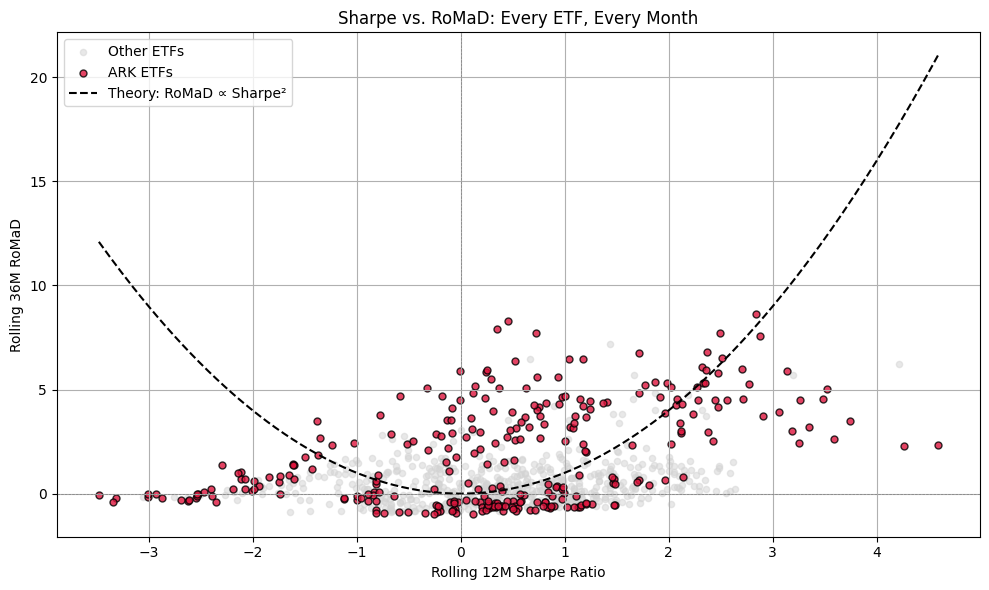

📊 Summary：
🧮 Total ETFs: 42
📈 Total Points (ETF × Months): 861
🔴 ARK ETFs: 6 — ARK Points: 293
⚪ Other ETFs: 36 — Other Points: 568


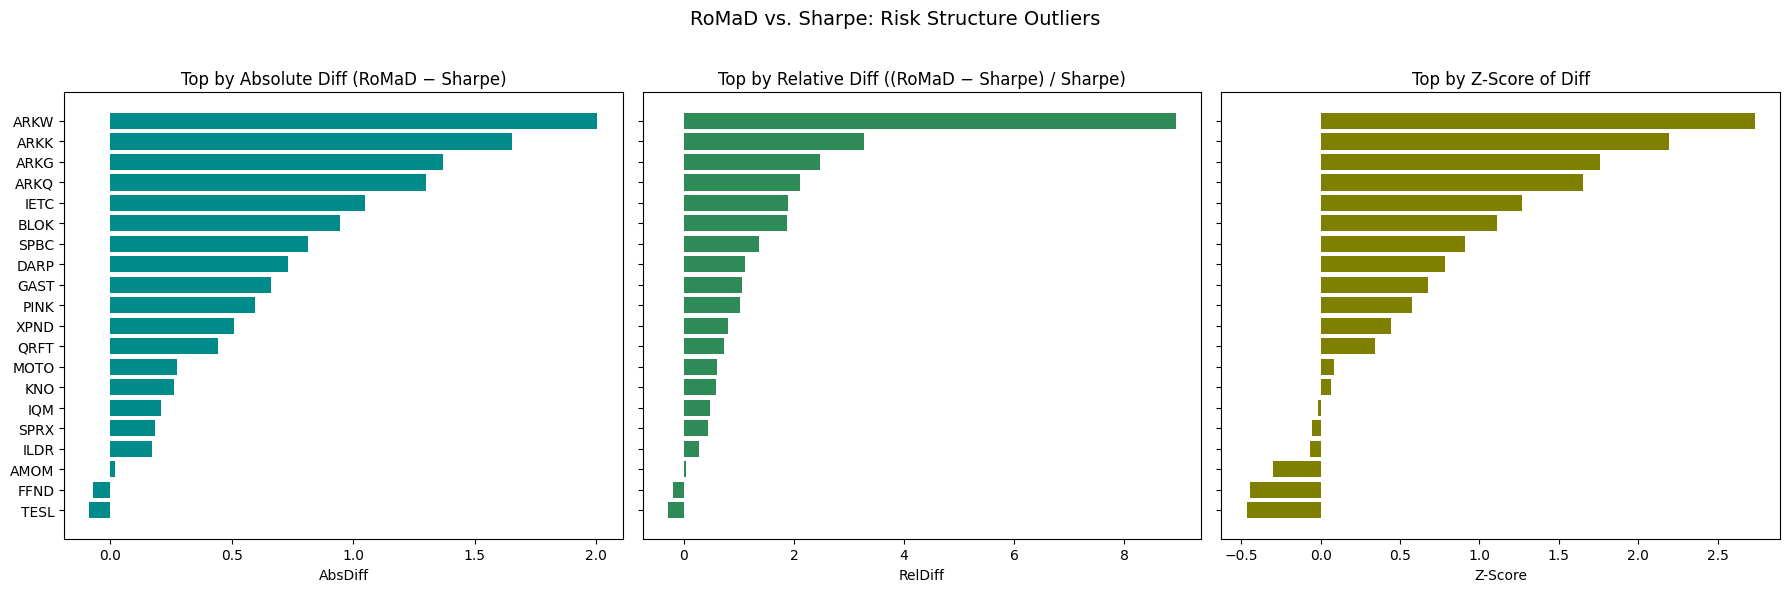

✅ Saved as '4.8 romad_minus_sharpe_all_variants_fixed.png'


In [61]:
if __name__ == "__main__":
    # ===== Step 1: Load ETF list =====
    tickers = load_etf_list(EXCEL_INPUT, EXCEL_SHEET)

    # ===== Step 2: Fetch daily prices =====
    df_close, failed = fetch_daily_close(tickers)

    if CORR_TARGET_ETF not in df_close.columns:
        raise ValueError(f"{CORR_TARGET_ETF} not found in price data.")
    
    # Align all prices to ARKK's start date
    start_date = df_close[CORR_TARGET_ETF].dropna().index.min()
    df_close = df_close[df_close.index >= start_date]
    print(f"📌 Data aligned to ARKK start date: {start_date.date()}")

    # ===== Step 3: Get risk-free rate =====
    risk_free_rate = get_risk_free_rate()
    print(f"📉 Monthly Risk-Free Rate: {risk_free_rate:.6f}")

    # ===== Step 4: Rolling 12-month Sharpe =====
    monthly_ret = df_close.resample("M").last().pct_change()
    rolling_sharpe = monthly_ret.rolling(window=12).apply(lambda r: compute_sharpe(r, risk_free_rate))
    rolling_sharpe.reset_index().to_excel("4.2 sharpe_ratio.xlsx", index=False)
    print("✅ Rolling Sharpe ratio saved.")

    # ===== Step 5: Rolling Return / MDD / RoMaD =====
    df_ret, df_mdd, df_rmd = {}, {}, {}
    for w in ROLLING_WINDOWS:
        monthly = df_close.resample("M").last().pct_change()
        ret = monthly.rolling(w).apply(lambda r: (1 + r).prod() - 1)

        mdd = df_close.rolling(w * 21).apply(lambda p: compute_max_drawdown(p))  # 21 trading days ≈ 1 month

        romad = ret / mdd.abs().replace(0, np.nan)

        df_ret[w], df_mdd[w], df_rmd[w] = ret, mdd, romad

    with pd.ExcelWriter("4.3 return_mdd.xlsx", engine="openpyxl") as writer:
        for w in ROLLING_WINDOWS:
            df_ret[w].reset_index().to_excel(writer, sheet_name=f"Return ({w}M)", index=False)
            df_mdd[w].reset_index().to_excel(writer, sheet_name=f"MDD ({w}M)", index=False)
            df_rmd[w].reset_index().to_excel(writer, sheet_name=f"Return_to_MDD ({w}M)", index=False)
    print("✅ Saved all return / MDD / RoMaD sheets.")

    # ===== Step 6: Pearson correlation =====
    print("📊 Calculating full-period Pearson correlation with ARKK...")
    daily_ret = df_close.pct_change()
    aligned_ret = daily_ret[[CORR_TARGET_ETF] + [etf for etf in df_close.columns if etf != CORR_TARGET_ETF]].dropna()
    pearson_corr = aligned_ret.corr()[CORR_TARGET_ETF].drop(CORR_TARGET_ETF).sort_values(ascending=False)
    pearson_corr.to_frame(name="Pearson Correlation with ARKK").to_excel("4.5 pearson_corr_with_ARKK.xlsx")
    print("✅ Pearson correlation saved.")

    # ===== Step 7: Optional - Rolling correlation  =====
    rolling_corr = compute_fixed_window_rolling_corr(df_close.pct_change(), CORR_TARGET_ETF, df_close.columns, 60)
    rolling_corr.to_excel("4.6 rolling_corr_manual.xlsx")

    # ===== Step 8: Sharpe Ratio - RoMad  =====
    sharpe_df = pd.read_excel("4.2 sharpe_ratio.xlsx", index_col="Date", parse_dates=True)
    romad_df = pd.read_excel("4.3 return_mdd.xlsx", sheet_name="Return_to_MDD (36M)", index_col="Date", parse_dates=True)

    analyze_sharpe_vs_romad_all_etfs_all_months(sharpe_df, romad_df)

    sharpe_df = pd.read_excel("4.2 sharpe_ratio.xlsx", index_col="Date", parse_dates=True)
    romad_df = pd.read_excel("4.3 return_mdd.xlsx", sheet_name="Return_to_MDD (36M)", index_col="Date", parse_dates=True)

    df_results = plot_romad_minus_sharpe_all_variants_fixed(sharpe_df, romad_df)

    df_results.to_excel("4.9 romad_vs_sharpe_comparison_full.xlsx")

